### Импорты


In [1]:
import pandas as pd
import copy

### Класс автобуса

In [2]:
class Bus():
    def __init__(self,busID, free = True, direction = True, workhr = 28, types = "СТ"):
        self.busID = busID
        self.free = free
        self.lunch = False
        #true - forward, false - back
        #Прямо, Обратно, Свободный
        self.direction = direction
        self.first = False
        self.workhr = pd.to_datetime(f"0:{workhr}", format= "%H:%M")
        self.smentime = pd.to_datetime(f"0:{workhr}", format= "%H:%M")
        self.aflunch = False #Changelog
        
        #время активности
        self.woktTime = pd.to_datetime(f"0:0", format= "%H:%M")
        
        #время через сколько будет обед:
        self.lunchT = pd.to_datetime(f"0:0", format= "%H:%M")
        #время через сколько будет смена:
        self.shift = pd.to_datetime(f"0:0", format= "%H:%M")
        
        #кол-во времени затраченных на обед:
        self.longLunch = 60
        self.periods = []
        
        self.type = types

    def change_free(self):
        self.free = not(self.free)
    def change_lunch(self):
        self.lunch = not(self.lunch)

    def change_dir(self):
        self.direction = not(self.direction)
        
    def set_time(self, time):
        self.timefree = time
        
    def first_start(self):
        self.first = True
    def addtime(self, time):
        self.workhr += pd.Timedelta( minutes=time)
        self.smentime += pd.Timedelta( minutes=time)
    def reset_time(self):
        self.workhr = pd.to_datetime("0:0", format= "%H:%M")
        
    def change_smen(self):
        self.smentime = pd.to_datetime("0:0", format= "%H:%M")
    
    def change_aflunch(self):
        self.aflunch = not(self.aflunch)
        
    def set_bez(self, last_pos, ntime):
        delta = ntime - last_pos
        self.timebez = delta.seconds/ 60
        
    def isActive(self, ntime):
        for per in self.periods:
            go = per[0]
            end = per[1]
            a = (ntime >= go and ntime < end)
            
            if a:
                return True
        return False
    
    def setType(self, s):
        self.type = s
        
    def addPeriods(self, start, stop):
        startT = pd.to_datetime(start, format= "%H:%M")
    
        stopT = pd.to_datetime(stop, format= "%H:%M")
        if stopT.hour < 3:
            stopT += pd.Timedelta(days = 1)
        self.periods.append((startT, stopT))
        
    def setLunchShift(self):
        minutT = self.woktTime.hour * 60 + self.woktTime.minute 
        self.lunchT += pd.Timedelta(minutes = minutT/4)
        self.shift += pd.Timedelta(minutes = minutT/2)
        if self.type == "СП":
            self.shift = pd.to_datetime(f"23:0", format= "%H:%M")
            self.lunchT = pd.to_datetime(f"23:0", format= "%H:%M")
        
        
        
    def setWorkTime(self):
        how_work = pd.to_datetime("0:0", format= "%H:%M")
        for period in self.periods:
            startT = period[0]
            stopT = period[1]
            if stopT.hour < 3:
                stopT += pd.Timedelta(days = 1)
            
            delta = stopT - startT
            
            how_work += pd.Timedelta(minutes = delta.seconds/60)
        self.woktTime = how_work
        self.setLunchShift()
    def setLongLunch(self, n):
        self.longLunch = n
        
        

        
        
        
        
class Station():
    def __init__(self, timestart, timestop, start, stop, types = "Рейс"):
        self.timestart = timestart
        self.timestop = timestop
        self.start = start
        self.stop = stop
        self.type = types
    def print_info(self):
        start = self.timestart.strftime("%X")
        stop = self.timestop.strftime("%X")
        return start, stop, self.start, self.stop, self.type
    def get_time(self):
        return self.timestop - self.timestart
        
    




In [61]:
kjh = pd.to_datetime("18:30", format= "%H:%M").hour * 60  + pd.to_datetime("18:30", format= "%H:%M").minute 
print(kjh / 2 /60)

9.25


### Подготовка


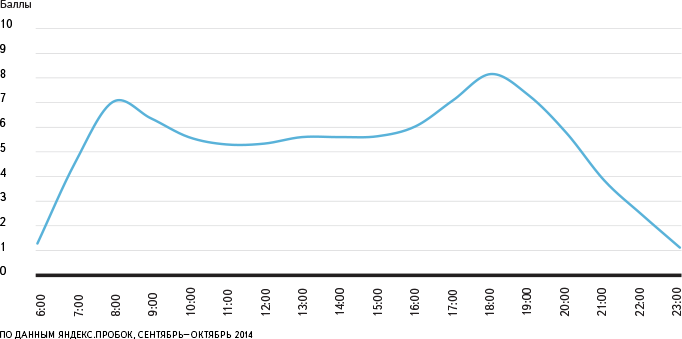

#### Парсер

In [73]:
def pars_exel(namefile, startcol = "Q", endcol = "U"):
    header = ["time", "countf", "delayf", "countb", "delayb"]
    cols = startcol + ":" + endcol
    df_timetable = pd.read_excel(namefile,names = header,   usecols=cols,skiprows = 25, nrows = 48 )
    
    #Переведем время в datetime
    df_timetable["time_dt"] = df_timetable["time"].apply(lambda x: pd.to_datetime(x, format= "%H:%M"))
    df_timetable.loc[df_timetable["delayf"] == "нет рейсов", "delayf"] = 0
    df_timetable.loc[df_timetable["delayb"] == "нет рейсов", "delayb"] = 0
    
    return df_timetable
    




df_timetable = pars_exel('606.xlsx', "Q","U")

### MainTest


#### Функции:


In [4]:
def checkLunch(prevSt, nowSt):
    if prevSt.type != "Обед" and prevSt.type != "Смена":
        return False
    k = nowSt.timestart - pd.Timedelta( minutes=1)

    return k
#Проверка на возможность разрыва
#И добавление его, если возможен
def addGap(bus, dictt, busid):
    listbid = dictt[busid]
    if len(listbid) == 1:
        return 0
    curdot = listbid[-1]
    lastdot = listbid[-2]
    
    startime = curdot.timestart
    stoptime = lastdot.timestop
    delta = startime - stoptime
    if delta.seconds/60 > 40:
#         print(delta.seconds/60, startime, stoptime, delta)
        st = Station(stoptime, startime, lastdot.stop,lastdot.stop, "Рарзыв") 
        dictt[busid].insert(-1, st)

#Добавление точки маршрута
def addToTT(bus, countbus, dictt, ntime, minute, second, direction, lp = " "):
    stoptime = ntime + pd.Timedelta(minutes = minute, seconds = second)
    nhour = ntime.hour
    #Костыль
#     if direction == "обед"and (nhour >= 23 and nhour == 24 or nhour <= 2):
#         return 0
#     if direction == "смена"and (nhour >= 18 and nhour <= 24 or nhour <= 2):
#         return 0
    #Костыль
    if direction == True:
        st = Station(ntime, stoptime, "НП","КП") 
    elif direction == False:
        st = Station(ntime, stoptime, "КП","НП") 
    elif direction == "нулевой пробег":
        st = Station(ntime, stoptime, "Парк","НП", "Нулевой пробег") 
    elif direction == "обед":
        st = Station(ntime, stoptime, lp, lp, "Обед")
        
    elif direction == "смена":
        st = Station(ntime, stoptime, lp, lp, "Смена") 
        
    if len(dictt[bus.busID]) != 0:  
        prSt = dictt[bus.busID][-1]
        time2 = checkLunch(prSt,st)

        if time2 != False:
        
            dictt[bus.busID][-1].timestop = time2
    
    
    dictt[bus.busID].append(st)
    banfree = ["смена", "обед"]
    if direction not in banfree:
        bus.change_free()
    
    lastsendf = ntime
    countbus += 1
    addGap(bus, dictt, bus.busID)
    return countbus, lastsendf

#Смена фазы времени
def changePhase(ntime, df_timetable):
    row = df_timetable.loc[df_timetable["time_dt"] == ntime]
    cbf = int(row["countf"])
    cbb = int(row["countb"])
    delf = int(row["delayf"])
    delb = int(row["delayb"])
    nextidx = row.index.to_list()[0]+1
    if nextidx >= df_timetable.shape[0]:
        nextidx = df_timetable.shape[0]-1
    return cbf, cbb, delf, delb, nextidx


def changeNextPhase(index, df_timetable):
    row = df_timetable.loc[index]
    time = row["time_dt"]
    cbf = int(row["countf"])
    cbb = int(row["countb"])
    nextdel = int(row["delayf"])
    
    return cbf, cbb, nextdel
    
#Ласт и Ферст можно объеденить, чтобы за один прогон всё добавлять    
def addLast(dictt, addtime):
    for key in dictt.keys():
        
        lastdot = dictt[key][-1]
        if lastdot.type == "Обед":
            dictt[key].pop()
            lastdot = dictt[key][-1]
        lastend = lastdot.timestop
        
        end = lastend + pd.Timedelta(minutes=addtime)
        stop = lastdot.stop
        st = Station(lastend, end, stop,"Парк", "Нулевой пробег") 
        dictt[key].append(st)
        
def addFirst(dictt, addtime):
    for key in dictt.keys():
        firstdot = dictt[key][0]
        firstart = firstdot.timestart
        delttime = firstdot.get_time().seconds//60
        start = firstart - pd.Timedelta(minutes=5+delttime)
        end = start + pd.Timedelta(minutes=delttime)
        st = Station(start, end, "Парк","НП", "Нулевой пробег") 
        dictt[key].insert(0, st)
        
        

    
#Смена времени движения автобуса в зависимости от времени        
def changeRoadTime(nowtime, oportime):
    nowhour = nowtime.hour
    if 8 <= nowhour < 10:
        return int(oportime*0.9)
    elif 18 <= nowhour < 20:
        return oportime
    elif 10 <= nowhour < 18:
        return int(oportime*0.8)
    else:
        return int(oportime*0.7)

def deltTime(bus, nowStop, lastPointTime):
    delt = nowStop - lastPointTime
#     print(nowStop, lastPointTime)
#     print(delt.total_seconds()/60)
    bus.addtime(delt.total_seconds()/60)
    
    
    



        
        
        
    

In [123]:
# def set_time_active(buspark, dt_timetable, countST, countSP):
#     exstremuns = []
#     max_count = 0
    
#     hours_work = {}
#     for row in dt_timetable.itertuples():
#         time = row.time
#         summ = row.countf + row.countb
#         if summ > max_count:
#             exstremuns = []
#             max_count = summ
#         if summ == max_count:
#             exstremuns.append(time)
            
#         if summ != 0:
#             hours_work[time] = summ
    
    
    
#     c_bus = 0
#     testv = {}
#     #
#     for i in buspark:
#         testv[i.busID ] = []
#     #
#     countnorm = int(countST * 0.5)
#     countshort = countnorm + int(countST * 0.16) + 1
#     countlong =  countshort + int(countST * 0.16) + 1
#     print(countnorm, countshort, countlong)
#     hr = [i for i in range(countST + countSP)]
#     for i in buspark:
#         if i.type == "СП":
#             hr[i.busID-1] = 4
#         else:
#             print(i.busID)
#             if i.busID <= countnorm:
#                 hr[i.busID-1] = 18
#             elif i.busID <= countshort:
#                 hr[i.busID-1] = 16
#             elif i.busID <= countlong:
#                 hr[i.busID-1] = 20
#             elif i.busID == countST:
#                 hr[i.busID-1] = 14.5
#     print(hr)
            
        
    
    
#     for k, v in hours_work.items():
#         time = pd.to_datetime(k, format= "%H:%M")
#         if time.hour < 3:
#             time +=  pd.Timedelta(days = 1)
#         for j in buspark:
#             if c_bus < v:
        
#                 if len(testv[j.busID]) == 0 or testv[j.busID][-1][-1] != 0:
#                     testv[j.busID].append([time, 0])
#                     c_bus += 1
                
#             else:
#                 break
        
#         for j in buspark:
#             if c_bus > v  and len(testv[j.busID]) != 0 and testv[j.busID][-1][-1] == 0:
#                 workhr = time - testv[j.busID][-1][0] 
#                 kjh = workhr.total_seconds() / 60 / 60
#                 if kjh > hr[j.busID-1]:
#                     testv[j.busID][-1][-1] = time 
#                     c_bus -= 1
#         print(k,v, c_bus)
                
#     for k, v in testv.items():
#         print(k, v)
    
            
        
#         ориг
    

In [178]:
def set_time_active(buspark, dt_timetable, countST, countSP):
    exstremuns = []
    max_count = 0
    
    hours_work = {}
    end = False
    for row in dt_timetable.itertuples():
        time = row.time
        summ = row.countf + row.countb
        if summ > max_count:
            exstremuns = []
            max_count = summ
        if summ == max_count:
            exstremuns.append(time)
            
        if summ != 0:
            hours_work[time] = summ
            end = True
        elif end and summ == 0:
            hours_work[time] = summ
            end = False
    
    
    
    print(exstremuns)
    
    start_bus = [buspark[i] for i in range(countST)]
    stop_bus = []
    c_bus = 0
    testv = {}
    fl = True
    
    for i in buspark:
        testv[i.busID ] = []
    
    #Проработка  СТ нарядов
    for k, v in hours_work.items():
        if k == exstremuns[0] or k == exstremuns[-1]:
            fl = not(fl)
            continue
        
        if fl:
            for j in start_bus:
                if c_bus < v:
#                   testv[j.busID].append([k, 0])
                    testv[j.busID] = [k, 0]
                    c_bus += 1
                    stop_bus.append(j)
                    start_bus.remove(j)
                    
            for j in stop_bus[::-1]:
                if c_bus > v:
                    testv[j.busID][-1] = k
                    c_bus -= 1
                    stop_bus.remove(j)
        print(k,v, c_bus)
                    
    #Проработка СП нарядов
                
    for k, v in testv.items():
        print(k, v)
    
            
        
        
    

In [179]:
test_d = main_rasp(40, df_timetable)
# test_df = dict_to_df(test_d)
# export_excel(test_df, "alter_test10")

['07:30', '08:00', '08:30', '17:30', '18:00', '19:00', '19:30']
05:00 1 1
05:30 3 3
06:00 6 5
06:30 7 6
07:00 6 6
08:00 8 6
08:30 8 6
09:00 6 6
09:30 6 6
10:00 4 6
10:30 4 6
11:00 5 6
11:30 6 6
12:00 6 6
12:30 6 6
13:00 6 6
13:30 6 6
14:00 6 6
14:30 6 6
15:00 6 6
15:30 6 6
16:00 6 6
16:30 6 6
17:00 7 6
17:30 8 6
18:00 8 6
18:30 6 6
19:00 8 6
20:00 5 5
20:30 6 5
21:00 4 4
21:30 4 4
22:00 4 4
22:30 4 4
23:00 3 3
23:30 3 3
00:00 3 3
00:30 1 1
01:00 0 0
1 ['05:00', '01:00']
2 ['05:30', '00:30']
3 ['06:00', '23:00']
4 ['05:30', '00:30']
5 ['06:30', '20:00']
6 ['06:00', '21:00']
7 []
8 []


In [115]:
def main_rasp(oportime, df_timetable, count = 8):
    dirtt = {} #словарь со списками точек входа/выхода для каждого автобуса

    buspark = [] #парк автобусов
    for i in range(8):
        if i > 5:
            buspark.append(Bus(i+1, types = "СП"))
        else:
            buspark.append(Bus(i+1))
        dirtt[i+1] = []
        
    set_time_active(buspark, df_timetable, 6, 2)
    
    return 0
    
    sttime = [["5:00", "23:00"],
              ["5:30", "23:30"], 
              ["5:30", "01:00"], 
              ["6:00", "00:00"],
              ["6:00", "22:00"], 
              ["6:30", "20:00"], 
              [["6:30", "11:00"],["13:00","16:00"], ["17:00", "20:00"]],
              [["7:30", "12:00"],["13:00","16:00"], ["17:00", "20:00"]]]
    for j in buspark:
        if j.type == "СП":
            sk = sttime[j.busID-1]
            j.setLongLunch(30)
            for pol in sk:
                j.addPeriods(pol[0], pol[1])
        else:
            sk = sttime[j.busID-1]
            j.setLongLunch(55)
            j.addPeriods(sk[0], sk[1])
        j.setWorkTime()
        

    ftime = pd.to_datetime(df_timetable["time"][0], format= "%H:%M")


    busline = []



    #Убрать потом
    avtfs = 0
    avtbs = 0

    mintofirst = 25

    #-------------

    nowbusf = 0
    nowbusb = 0


    waitb = 0
    waitf = 8

    nowlunch = []

    lastsendf = pd.to_datetime("0:0", format= "%H:%M")
    lastsendb = pd.to_datetime("0:0", format= "%H:%M")
    lastfirst = pd.to_datetime("0:0", format= "%H:%M")
    
    
    
    chetnii = False
    for i in range(24):

        for k in range(0, 60, 2):
            chetnii = not(chetnii)
            #нынешнее время
            ntime = ftime + pd.Timedelta(hours = i, minutes=k)
            changtime = ntime 
            if ntime.day == 2:
                changtime -= pd.Timedelta(days = 1)

            #смена фазы
            if df_timetable["time_dt"].isin([changtime]).any():
                activeBus = []
                cbf, cbb, delf, delb, nextidx = changePhase(changtime, df_timetable)
                for auto in buspark:
                    if auto.isActive(ntime):
                        activeBus.append(auto)
#                 print(ntime, cbf + cbb)
#                 for lkj in activeBus:
#                     print(lkj.busID, sep = " ")
#                 print("\n")
            #время в минутах после последней отправки
            deltasendf = (ntime - lastsendf).seconds/60
            deltasendb = (ntime - lastsendb).seconds/60
            deltafirst = (ntime - lastfirst).seconds/60

            ncbf, ncbb, nextdel = changeNextPhase(nextidx, df_timetable)
            avtfm = changeRoadTime(ntime, oportime) # смена времени в пути
            avtbm = avtfm





            #вычет
            if (nowbusf + nowbusb) != 0:
                for j in buspark:
                    if not(j.free):
                        if dirtt[j.busID][-1].timestop < ntime:
                            j.change_free()
                            if j.direction:
                                nowbusf -= 1
                                waitb += 1


                            else: 
                                nowbusb -= 1 
                                waitf += 1
                            j.change_dir()
            #добавление
            if (nowbusf + nowbusb) < (cbf + cbb) :
                #переделать в отдельную функцию
                for j in activeBus:
                    

                


                    deltasendf = (ntime - lastsendf).seconds/60
                    deltasendb = (ntime - lastsendb).seconds/60
                    

                    if j.free and not(j.lunch):
                        
                        if j.smentime > j.shift:
                            j.change_lunch()
                            lp = dirtt[j.busID][-1].stop
                            addToTT(j, 0, dirtt, ntime, 10, 0, "смена", lp)
                            nowlunch.append(j)
    #                         print(f"{j.busID} пошел на смена")



                        elif j.workhr > j.lunchT:
                            j.change_lunch()
                            j.addtime(j.longLunch)
                            lp = dirtt[j.busID][-1].stop

                            addToTT(j, 0, dirtt, ntime, j.longLunch, 0, "обед", lp)
                            nowlunch.append(j)
                            j.aflunch = True
    #                         print(f"{j.busID} пошел на обед")
                        elif nowbusf != cbf and j.direction and (deltasendf - delf) >= 0:
                            nowbusf, lastsendf = addToTT(j, nowbusf, dirtt, ntime, avtfm, avtfs, True)
    #                         print(f"{j.busID} отправил вперед")
                            waitf -= 1
                            if len(dirtt[j.busID]) > 1:
                                lpTime = dirtt[j.busID][-2].timestop
                                nowStop = dirtt[j.busID][-1].timestop
                                deltTime(j, nowStop, lpTime)
                            else:
                                j.addtime(avtfm+1)

                        elif nowbusb != cbb and not(j.direction) and (deltasendb - delb) >= 0:
                            nowbusb, lastsendb = addToTT(j, nowbusb, dirtt, ntime, avtbm, avtbs, False)
    #                         print(f"{j.busID} отправил назад")
                            waitb -= 1
                            if len(dirtt[j.busID]) > 1:
                                lpTime = dirtt[j.busID][-2].timestop
                                nowStop = dirtt[j.busID][-1].timestop
                                deltTime(j, nowStop, lpTime)
                            else:
                                j.addtime(avtbm+1)



            if nowlunch:
                for j in nowlunch:
                    if dirtt[j.busID][-1].timestop < ntime: 
                        if dirtt[j.busID][-1].type == "Смена":
                            j.change_smen()
                            j.aflunch = False
                        j.change_lunch()
                        j.reset_time()
                        nowlunch.remove(j)


#             if k % 3 == 0:
#                 for j in buspark:
#                     busID = j.busID
#                     if j.free and not(j.lunch) and len(dirtt[busID]) > 0:
#                         lastPoint = dirtt[busID][-1].timestop
#                         j.set_bez(lastPoint, ntime)
#                         if j.timebez > 40 and not(j.aflunch):
#                             j.change_aflunch()
#                             j.change_lunch()
#                             tst = lastPoint + pd.Timedelta(minutes=5)
#                             lp = dirtt[j.busID][-1].stop
#                             addToTT(j, 0, dirtt, tst, lunch, 0, "обед", lp)
#                             nowlunch.append(j)
                            
        
                            
                            
                    
                            




            print(ntime, nowbusf, nowbusb, cbf, cbb, deltasendf, deltasendb, delf, delb, waitf, waitb)
    addLast(dirtt, mintofirst)
    addFirst(dirtt, mintofirst)
    
    return dirtt
def dict_to_df(dirtt):
    df2 = pd.DataFrame(columns=['busID', 'TimeStart', 'TimeStop','TypeStart','TypeStop',"TypeDir"])
    for k,v in dirtt.items():
        for i in dirtt[k]:
            info = i.print_info()
            new_row = [[k, info[0],info[1],info[2],info[3],info[4]]]
            df2 = pd.concat([df2, pd.DataFrame(new_row, columns=df2.columns)], ignore_index=True)
    return df2
def export_excel(df2, name):
    df2.to_excel(f'{name}.xlsx')
    
    
                    

                        
            
            
            

            